In [1]:
import xarray as xr
import polars as pl
import glob
import pandas as pd
import re
from datetime import datetime
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic

### Open Gliders files

In [2]:


# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "PRAC_SALINITY", "MOLAR_DOXY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

# Add a 'glider_name' column by extracting the part before '_' in 'profile_id'
df_concat = df_concat.with_columns(
    pl.col("profile_id").str.split("_").list.get(1).alias("glider_name")
)


C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 12)


### Open CTD files

In [3]:
def read_ctd(filepath):


    # Read column names from line 27 (R skips 26 lines, so read line 27 as header)
    cols = pd.read_csv(filepath, skiprows=26, nrows=0)
    cols_name = cols.columns.tolist()

    # Read actual data (R skips 28 lines, so data starts at line 29)
    dat = pd.read_csv(filepath, skiprows=28, header=None)
    dat.columns = cols_name

    # Read raw lines for metadata
    with open(filepath, "r") as f:
        raw_dat = f.readlines()

    # Extract LON
    lon_line = next(line for line in raw_dat if "LON" in line)
    lon = float(re.search(r"=(.*)", lon_line).group(1).strip())

    # Extract LAT
    lat_line = next(line for line in raw_dat if "LAT" in line)
    lat = float(re.search(r"=(.*)", lat_line).group(1).strip())

    # Add to dataframe
    dat["lon"] = lon
    dat["lat"] = lat

    # Extract DATE (second match, as in R)
    date_lines = [line for line in raw_dat if "DATE" in line]
    date_str = re.search(r"=(.*)", date_lines[1]).group(1).strip()
    date_val = pd.to_datetime(date_str).date()

    # Extract TIME
    time_line = next(line for line in raw_dat if "TIME" in line)
    time_str = re.search(r"= (.*)", time_line).group(1).strip()

    # Parse TIME (e.g. "1025" → "10:25")
    time_str_formatted = re.sub(r"^([0-9]{2})([0-9]+)$", r"\1:\2", time_str)
    time_val = pd.to_datetime(time_str_formatted, format="%H:%M").time()

    # Combine date and time
    datetime_val = datetime.combine(date_val, time_val)

    # Add datetime to dataframe
    dat["datetime"] = datetime_val
    return dat

In [4]:
# Define the parent directory
parent_dir = "C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/CTD/DY180/74EQ20240522_ct1"

# List to hold each parsed DataFrame
dataframes = []
idx = 1
# Loop through all files in the parent directory and subdirectories
for root, dirs, files in os.walk(parent_dir):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            try:
                df = read_ctd(file_path)
                df['profile_idx'] = idx
                dataframes.append(df)
                idx += 1
            except Exception as e:
                print(f"Failed to read {file_path}: {e}")

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Display summary
print(f"Loaded {len(dataframes)} files. Combined shape: {combined_df.shape}")

Loaded 52 files. Combined shape: (21863, 19)


### Make a plot to show distance of gliders

In [5]:
# Group by 'profile_id' and 'glider_name', then aggregate median datetime, longitude, latitude
summary = (
    df_concat
    .group_by(['profile_id', 'glider_name'])
    .agg([
        pl.col('TIME').median().alias('median_datetime'),
        pl.col('LONGITUDE').median().alias('median_longitude'),
        pl.col('LATITUDE').median().alias('median_latitude')
    ])
    .sort('median_datetime')
)

# Convert to pandas DataFrame for easier display if needed
summary_pd = summary.to_pandas()
summary_pd.head()

,profile_id,glider_name,median_datetime,median_longitude,median_latitude
0,1.0_Cabot,Cabot,2024-05-28 12:59:48.193740288,-24.001507,60.000038
1,1.0_Nelson,Nelson,2024-05-28 16:10:32.929382912,-23.953222,59.933823
2,2.0_Nelson,Nelson,2024-05-28 16:44:54.573363968,-23.945343,59.931000
3,3.0_Nelson,Nelson,2024-05-28 16:49:53.522613248,-23.944508,59.930759
4,4.0_Nelson,Nelson,2024-05-28 17:15:59.081421312,-23.940367,59.930614


In [6]:
# Create a summary table from combined_df with one line per profile (grouped by 'datetime', 'lon', 'lat')
ctd_summary = (
    combined_df[['datetime', 'lon', 'lat', 'profile_idx']]
    .drop_duplicates()
    .reset_index(drop=True)
)

ctd_summary.head()

,datetime,lon,lat,profile_idx
0,2024-05-26 12:11:00,-22.49730,59.18032,1
1,2024-05-27 04:37:00,-24.00044,60.00012,2
2,2024-05-27 07:40:00,-24.00042,60.00014,3
3,2024-05-28 03:33:00,-24.00016,60.00016,4
4,2024-05-28 05:28:00,-24.00020,60.00018,5


In [7]:
# Prepare arrays for glider and CTD profile locations and times
glider_times = summary_pd['median_datetime'].values
glider_lons = summary_pd['median_longitude'].values
glider_lats = summary_pd['median_latitude'].values

ctd_times = ctd_summary['datetime'].values
ctd_lons = ctd_summary['lon'].values
ctd_lats = ctd_summary['lat'].values

# For each glider profile, find the closest CTD profile in time and compute distance
closest_ctd_idx = []
closest_time_diff = []
distance_km = []

import numpy as np

for g_time, g_lat, g_lon in zip(glider_times, glider_lats, glider_lons):
    # Find index of closest CTD profile in time
    time_diffs = abs(ctd_times - g_time)
    idx = time_diffs.argmin()
    closest_ctd_idx.append(idx)
    closest_time_diff.append(time_diffs[idx])
    # Compute distance in km, handle nan coordinates
    glider_pos = (g_lat, g_lon)
    ctd_pos = (ctd_lats[idx], ctd_lons[idx])
    if np.isfinite(g_lat) and np.isfinite(g_lon) and np.isfinite(ctd_lats[idx]) and np.isfinite(ctd_lons[idx]):
        dist = geodesic(glider_pos, ctd_pos).km
    else:
        dist = np.nan
    distance_km.append(dist)

# Add results to summary_pd
summary_pd['closest_ctd_idx'] = closest_ctd_idx
summary_pd['ctd_time_diff'] = closest_time_diff
summary_pd['ctd_distance_km'] = distance_km

summary_pd[['profile_id', 'glider_name', 'median_datetime', 'closest_ctd_idx', 'ctd_time_diff', 'ctd_distance_km']].head()

,profile_id,glider_name,median_datetime,closest_ctd_idx,ctd_time_diff,ctd_distance_km
0,1.0_Cabot,Cabot,2024-05-28 12:59:48.193740288,5,0 days 01:15:48.193740288,0.068635
1,1.0_Nelson,Nelson,2024-05-28 16:10:32.929382912,5,0 days 04:26:32.929382912,7.849181
2,2.0_Nelson,Nelson,2024-05-28 16:44:54.573363968,5,0 days 05:00:54.573363968,8.298804
3,3.0_Nelson,Nelson,2024-05-28 16:49:53.522613248,5,0 days 05:05:53.522613248,8.341018
4,4.0_Nelson,Nelson,2024-05-28 17:15:59.081421312,5,0 days 05:31:59.081421312,8.445026


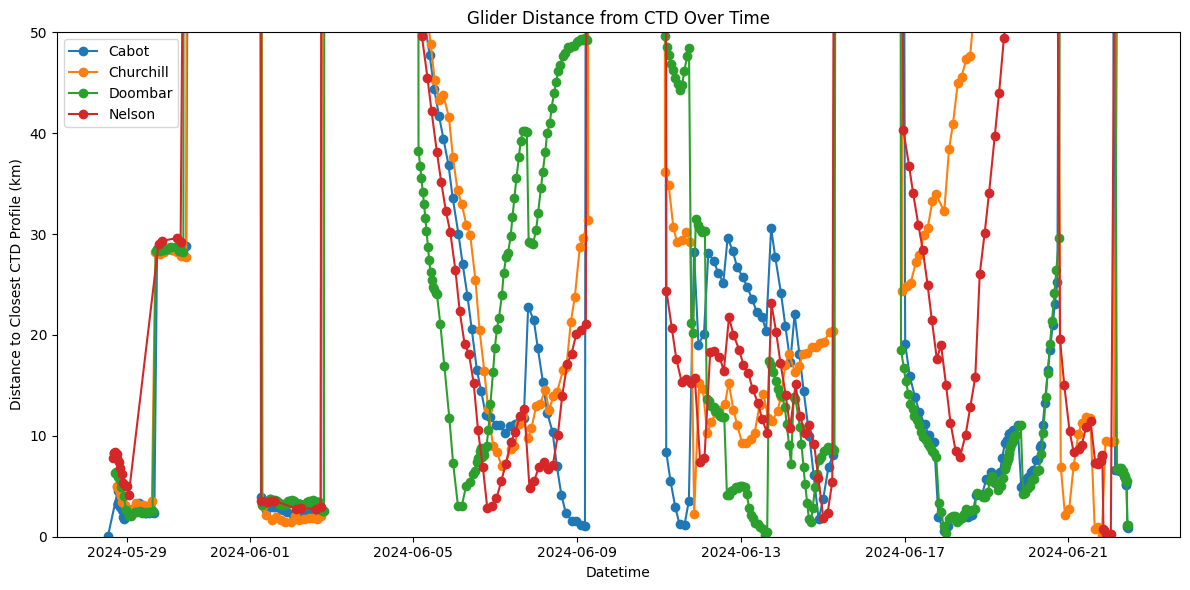

In [8]:

# Get the last CTD profile datetime
last_ctd_time = ctd_times[-1]

# Filter summary_pd to only include glider profiles up to the last CTD profile datetime
mask = summary_pd['median_datetime'] <= last_ctd_time
filtered = summary_pd[mask]

# Plot
plt.figure(figsize=(12, 6))
for name, group in filtered.groupby('glider_name'):
    plt.plot(group['median_datetime'], group['ctd_distance_km'], label=name, marker='o', linestyle='-')

plt.xlabel('Datetime')
plt.ylabel('Distance to Closest CTD Profile (km)')
plt.ylim(0, 50)
plt.title('Glider Distance from CTD Over Time')
plt.legend()
plt.tight_layout()
plt.show()

### Generate a list of possible candidate profiles

In [9]:
import pandas as pd
from geopy.distance import geodesic

def find_candidate_glider_ctd_pairs(glider_df, ctd_df, time_thresh_hr=2, dist_thresh_km=5):
    """
    Identify all pairs of glider and CTD profiles within specified time (hours) and distance (km) thresholds.
    
    Returns a DataFrame of matching pairs with details.
    """
    matches = []
    
    for _, g_row in glider_df.iterrows():
        for _, c_row in ctd_df.iterrows():
            # Time difference
            time_diff_hr = abs((g_row['median_datetime'] - c_row['datetime']).total_seconds()) / 3600.0
            if time_diff_hr > time_thresh_hr:
                continue

            # Skip if coordinates are missing
            if pd.isnull(g_row['median_latitude']) or pd.isnull(g_row['median_longitude']) \
               or pd.isnull(c_row['lat']) or pd.isnull(c_row['lon']):
                continue

            # Distance in kilometers
            dist_km = geodesic(
                (g_row['median_latitude'], g_row['median_longitude']),
                (c_row['lat'], c_row['lon'])
            ).km

            if dist_km > dist_thresh_km:
                continue

            matches.append({
                'glider_profile_id': g_row['profile_id'],
                'glider_name': g_row['glider_name'],
                'ctd_profile_id': c_row.get('profile_idx', None),  # default to None if not present
                'time_diff_hr': time_diff_hr,
                'dist_km': dist_km
            })
    
    return pd.DataFrame(matches)



In [10]:
# Use the find_candidate_glider_ctd_pairs function with filtered and ctd_summary
candidates = find_candidate_glider_ctd_pairs(
    filtered,
    ctd_summary,
    time_thresh_hr=12,
    dist_thresh_km=20
)

print(f"Found {len(candidates)} candidate glider-CTD profile pairs within 12hr and 20km.")
# Show the first 5 candidates
candidates[:5]

Found 1038 candidate glider-CTD profile pairs within 12hr and 20km.


,glider_profile_id,glider_name,ctd_profile_id,time_diff_hr,dist_km
0,1.0_Cabot,Cabot,4,9.446720,0.076368
1,1.0_Cabot,Cabot,5,7.530054,0.074613
2,1.0_Cabot,Cabot,6,1.263387,0.068635
3,1.0_Nelson,Nelson,5,10.709147,7.844838
4,1.0_Nelson,Nelson,6,4.442480,7.849181


In [11]:

def plot_heatmap_glider_df(glider_name, df, time_bins, dist_bins):
    """
    Plot cumulative 2D histogram (heatmap) of matchups from a DataFrame for a specific glider.
    
    Parameters:
    - glider_name: str, the glider to filter
    - df: pd.DataFrame with required columns: 
          'glider_profile_id', 'glider_name', 'ctd_profile_id', 'time_diff_hr', 'dist_km'
    - time_bins: array-like, bin edges for time (in hours)
    - dist_bins: array-like, bin edges for distance (in km)
    """

    # Filter DataFrame for selected glider
    df_g = df[df['glider_name'] == glider_name]
    if df_g.empty:
        print(f"No matchups found for glider '{glider_name}'.")
        return

    # Extract arrays for histogram
    time_diffs = df_g['time_diff_hr'].values
    dist_kms = df_g['dist_km'].values

    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(time_diffs, dist_kms, bins=[time_bins, dist_bins])

    # Cumulative sum along both axes
    H_cum = H.cumsum(axis=0).cumsum(axis=1)

    # Plot heatmap
    X, Y = np.meshgrid(yedges, xedges)
    plt.figure(figsize=(9, 7))
    plt.pcolormesh(X, Y, H_cum, cmap='PuBu', shading='auto')
    plt.colorbar(label='Cumulative Number of Matchups')
    plt.xlabel('Distance Threshold (km)')
    plt.ylabel('Time Threshold (hr)')
    plt.title(f'Cumulative Matchups by Time/Distance\nGlider: {glider_name}')

    # Annotate each cell with value
    for i in range(H_cum.shape[0]):
        for j in range(H_cum.shape[1]):
            val = int(H_cum[i, j])
            if val > 0:
                x_center = (yedges[j] + yedges[j+1]) / 2
                y_center = (xedges[i] + xedges[i+1]) / 2
                color = 'white' if val > H_cum.max() / 2 else 'black'
                plt.text(x_center, y_center, str(val), ha='center', va='center', fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

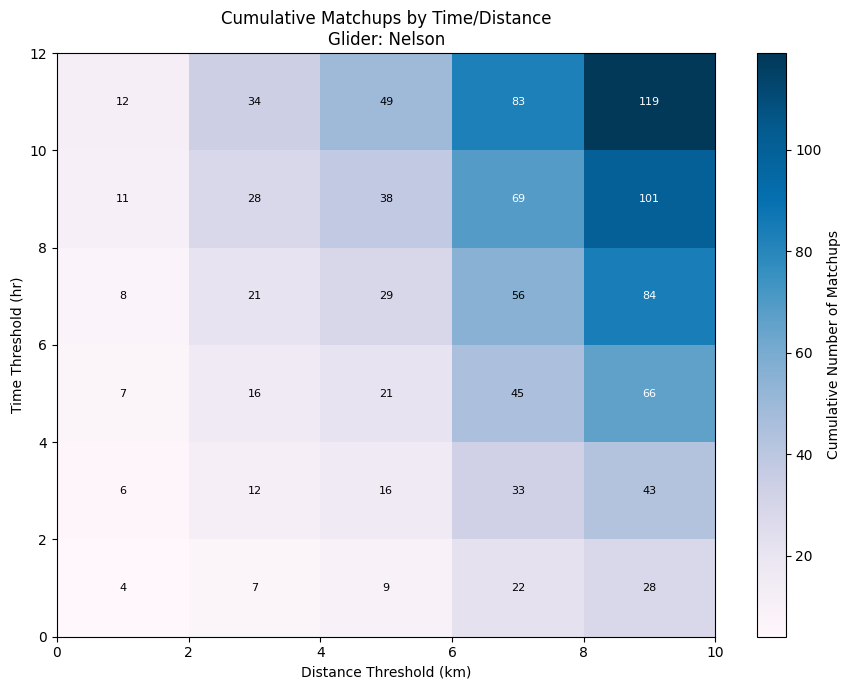

In [12]:
time_bins = np.arange(0, 13, 2) 
dist_bins = np.arange(0, 11, 2)
# Choose a specific glider, e.g., "Nelson"
glider_of_interest = "Nelson"
plot_heatmap_glider_df(glider_of_interest, candidates, time_bins, dist_bins)

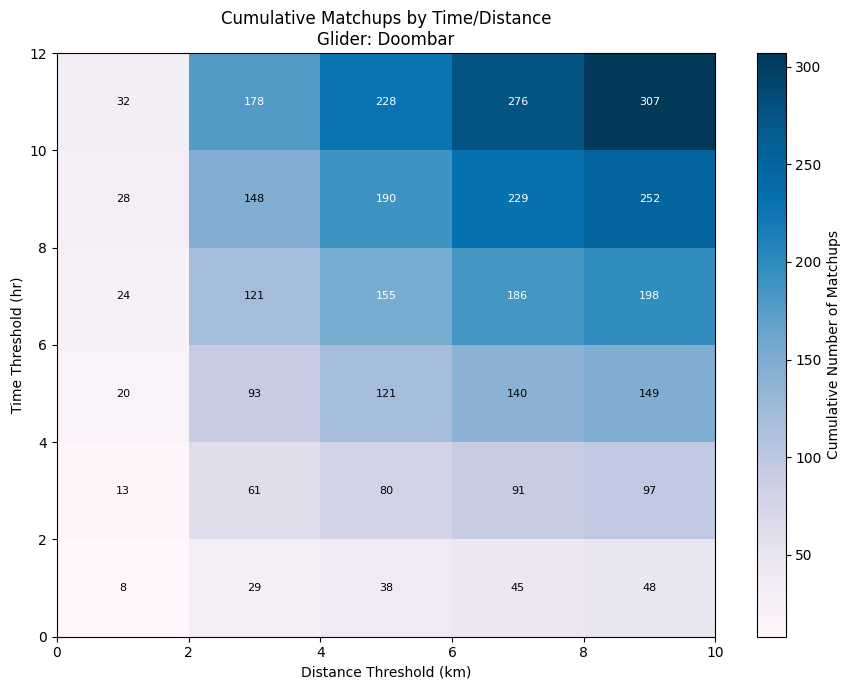

In [13]:
plot_heatmap_glider_df("Doombar", candidates, time_bins, dist_bins)

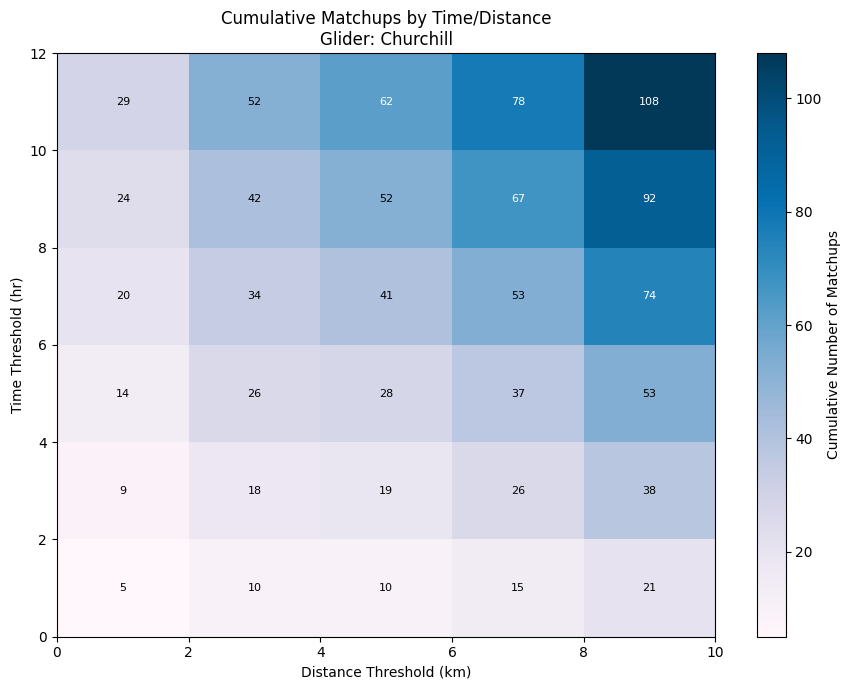

In [14]:
plot_heatmap_glider_df("Churchill", candidates, time_bins, dist_bins)

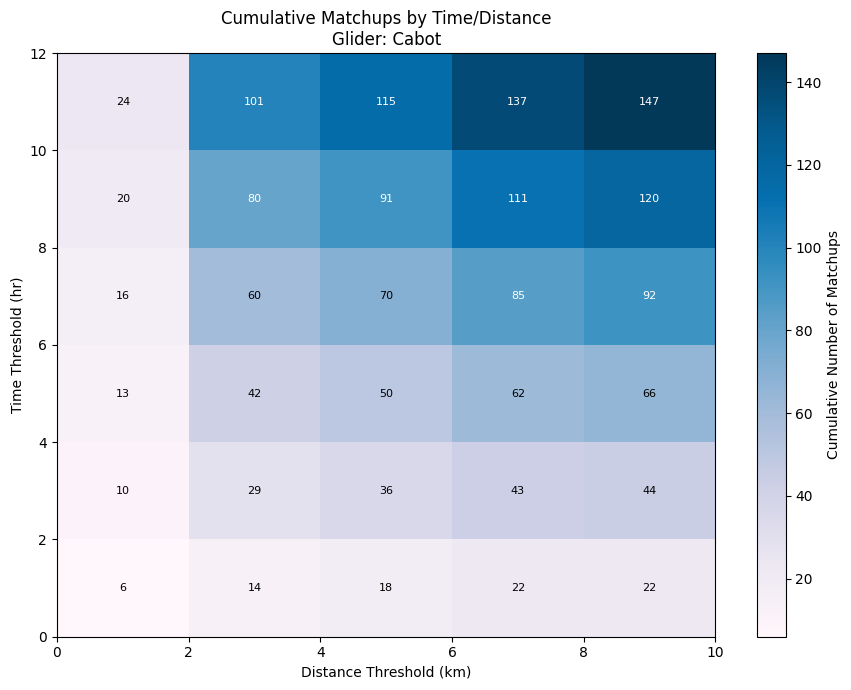

In [15]:
plot_heatmap_glider_df("Cabot", candidates, time_bins, dist_bins)

### Look at depth bin match up

In [16]:
# Interpolate DEPTH values per profile_id in df_concat (polars DataFrame)
# We'll use group_by and apply interpolation using polars' .interpolate() method

df_concat = (
    df_concat
    .sort(['profile_id', 'TIME'])
    .with_columns([
        pl.col('DEPTH')
        .interpolate()
        .over('profile_id')
        .alias('DEPTH_interp')
    ])
)

In [17]:
# Add a 'depth_bin' column to df_concat, binning 'DEPTH' in 50m intervals
df_concat = df_concat.with_columns(
    (-(pl.col("DEPTH_interp") // 5)).cast(pl.Int32).alias("depth_bin"))
# Add a 'depth_bin' column to combined_df, binning 'CTDPRS' in 50m intervals
combined_df['depth_bin'] = pd.to_numeric(combined_df['CTDPRS'], errors='coerce') // 5
combined_df['depth_bin'] = combined_df['depth_bin'].astype('Int32')

In [18]:
# Group by 'profile_id', 'glider_name', and 'depth_bin', then aggregate median for selected variables
glider_binned = (
    df_concat
    .group_by(['profile_id', 'glider_name', 'depth_bin'])
    .agg([
        pl.col('TEMP').median().alias('median_temp'),
        pl.col('PRAC_SALINITY').median().alias('median_salinity'),
        pl.col('CHLA').median().alias('median_chla'),
        pl.col('BBP700').median().alias('median_bbp'),
        pl.col('MOLAR_DOXY').median().alias('median_doxy')
    ])
    .sort(['profile_id', 'depth_bin'])
)
# Remove rows with any missing values in the aggregated table
glider_binned = glider_binned.drop_nulls()


In [19]:
ctd_binned = (
    combined_df
    .groupby(['datetime', 'lon', 'lat', 'depth_bin', 'profile_idx'], as_index=False)
    .agg({
        ' CTDTMP': 'median',
        ' CTDSAL': 'median',
        ' CTDTURB': 'median',
        ' CTDOXY': 'median',
        ' CTDFLUOR': 'median'
    })
)

ctd_binned = pl.from_pandas(ctd_binned)

In [20]:
# Convert candidates to polars DataFrame
candidates_pl = pl.from_pandas(candidates)

# Join all depth bins for each glider_profile_id from glider_binned
# This will add all depth-bin data for each candidate glider profile
candidates_with_bins = candidates_pl.join(
    glider_binned,
    left_on="glider_profile_id",
    right_on="profile_id",
    how="inner"
)


In [21]:
# Join ctd_binned data to candidates_with_bins using ctd_profile_id and depth_bin
final_matched = candidates_with_bins.join(
    ctd_binned,
    left_on=["ctd_profile_id", "depth_bin"],
    right_on=["profile_idx", "depth_bin"],
    how="inner"
)


In [22]:
from sklearn.linear_model import LinearRegression
import numpy as np
from utils.statistics import type2_regression_r2

# Group the final_matched DataFrame by 'glider_profile_id' and 'ctd_profile_id'
grouped = final_matched.to_pandas().groupby(['glider_profile_id', 'ctd_profile_id'])

# Define var_pairs: pairs of columns to compare between glider and CTD datasets
var_pairs = [
    ('median_temp', ' CTDTMP', 'r2_temp'),
    ('median_salinity', ' CTDSAL', 'r2_salinity'),
    ('median_chla', ' CTDFLUOR', 'r2_chla'),
    ('median_bbp', ' CTDTURB', 'r2_bbp'),
    ('median_doxy', ' CTDOXY', 'r2_doxy')
]

results = []
for keys, group in grouped:
    row = {'glider_profile_id': keys[0], 'ctd_profile_id': keys[1]}
    # Add time and distance from the first row in group
    first_row = group.iloc[0]
    row['time_diff_hr'] = first_row['time_diff_hr']
    row['dist_km'] = first_row['dist_km']
    
    for g_col, c_col, out_col in var_pairs:
        x = group[g_col].to_numpy()
        y = group[c_col].to_numpy()
        row[out_col] = type2_regression_r2(x, y)
    results.append(row)

# Convert to DataFrame
r2_df = pd.DataFrame(results)
r2_df.head()


c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\Scripts\Python\utils\statistics.py:25: RuntimeWarning: invalid value encountered in scalar divide
  s_yx = np.std(y_clean, ddof=1) / np.std(x_clean, ddof=1)
c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\Scripts\Python\utils\statistics.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  s_yx = np.std(y_clean, ddof=1) / np.std(x_clean, ddof=1)


,glider_profile_id,ctd_profile_id,time_diff_hr,dist_km,r2_temp,r2_salinity,r2_chla,r2_bbp,r2_doxy
0,1.0_Churchill,6,6.745727,4.995948,0.230377,0.686451,-0.421579,0.753172,-0.682469
1,1.0_Doombar,5,11.836677,6.322710,NaN,NaN,NaN,NaN,NaN
2,1.0_Doombar,6,5.570010,6.326953,NaN,NaN,NaN,NaN,NaN
3,10.0_Doombar,7,11.180101,2.053647,0.987247,0.801714,0.969626,0.862134,0.711562
4,100.0_Churchill,20,11.356362,11.727578,0.814471,-0.481598,0.855410,0.777578,0.944940



=== R² Heatmap for Nelson ===


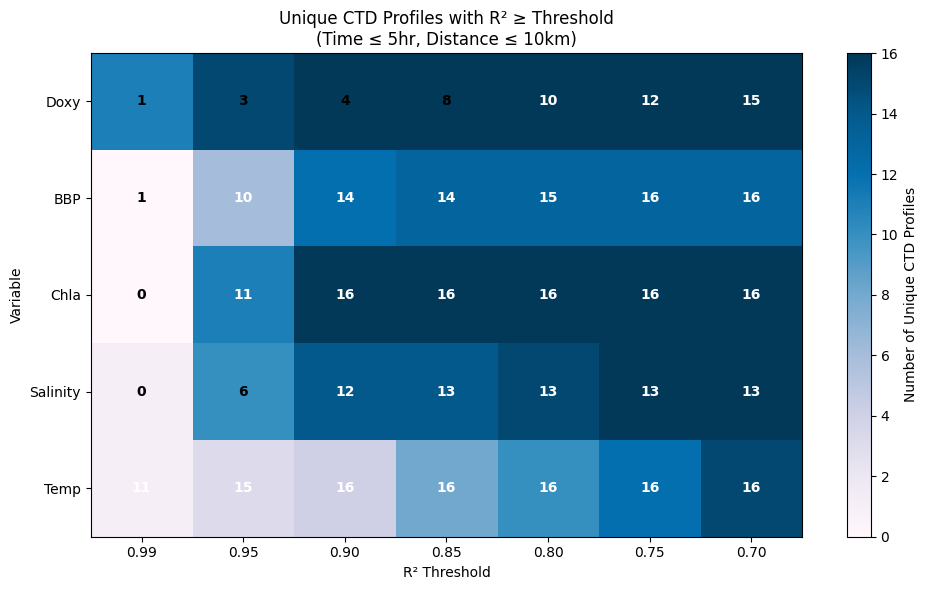


=== R² Heatmap for Doombar ===


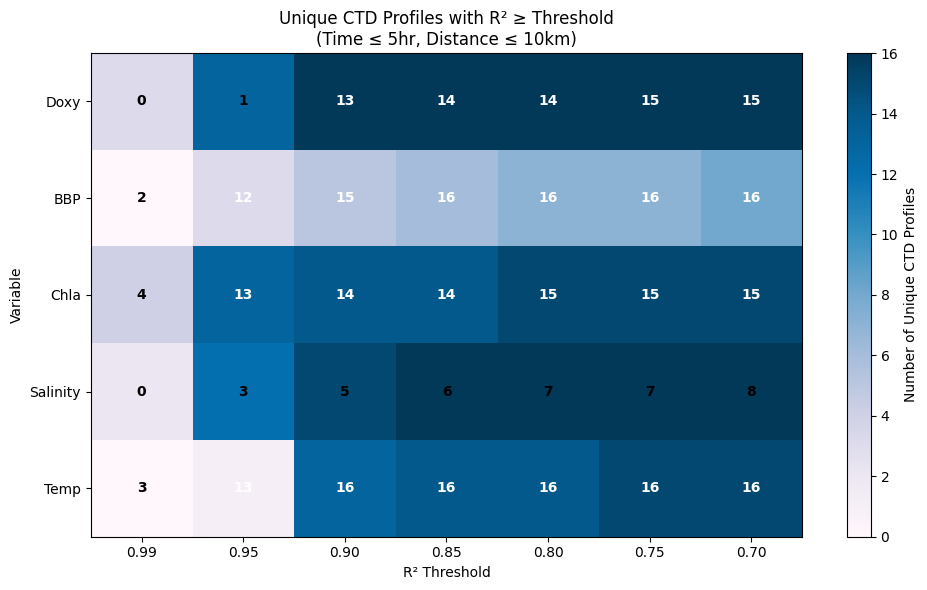


=== R² Heatmap for Churchill ===


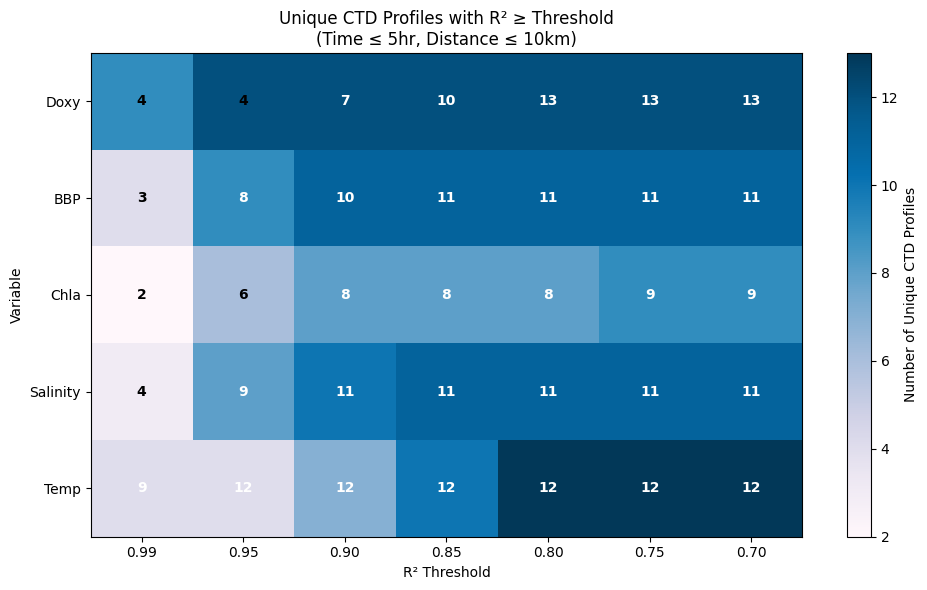


=== R² Heatmap for Cabot ===


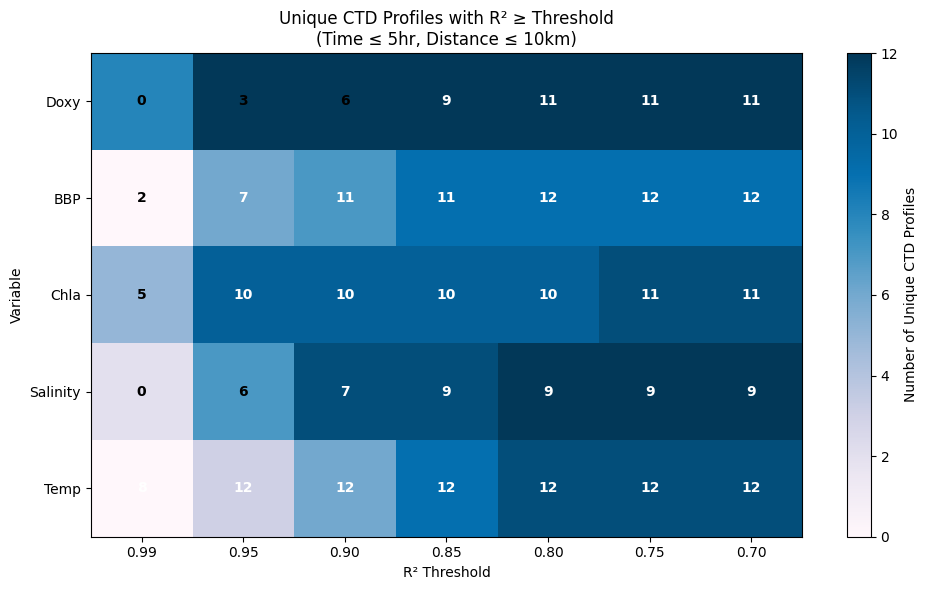

In [23]:
from utils.statistics import plot_r2_heatmap
# Filter the r2_df for each glider and run the heatmap function
gliders = ['Nelson', 'Doombar', 'Churchill', 'Cabot']

for glider in gliders:
    # Filter the dataset for the current glider
    filtered_r2_df = r2_df[r2_df['glider_profile_id'].str.contains(f"_{glider}$")]
    
    print(f"\n=== R² Heatmap for {glider} ===")
    plot_r2_heatmap(
        filtered_r2_df,
        time_thresh_hr=5,
        dist_thresh_km=10
    )


# Visualising the correlation

In [24]:
filtered_r2_df = r2_df[
    (r2_df['r2_temp'] >= 0.95) |
    (r2_df['r2_salinity'] >= 0.9) |
    (r2_df['r2_chla'] >= 0.9) |
    (r2_df['r2_bbp'] >= 0.9) |
    (r2_df['r2_doxy'] >= 0.9)
]

print(f"Filtered DataFrame contains {len(filtered_r2_df)} rows.")
filtered_r2_df.head()

Filtered DataFrame contains 845 rows.


,glider_profile_id,ctd_profile_id,time_diff_hr,dist_km,r2_temp,r2_salinity,r2_chla,r2_bbp,r2_doxy
3,10.0_Doombar,7,11.180101,2.053647,0.987247,0.801714,0.969626,0.862134,0.711562
4,100.0_Churchill,20,11.356362,11.727578,0.814471,-0.481598,0.855410,0.777578,0.944940
5,100.0_Churchill,21,4.623029,12.006675,0.970102,0.910971,0.804524,0.898272,0.109022
6,100.0_Churchill,22,10.226971,7.501200,0.972238,0.892147,0.929320,0.887400,0.203537
9,102.0_Churchill,21,9.637535,18.113315,0.974903,0.895302,0.851089,0.941623,-0.028293


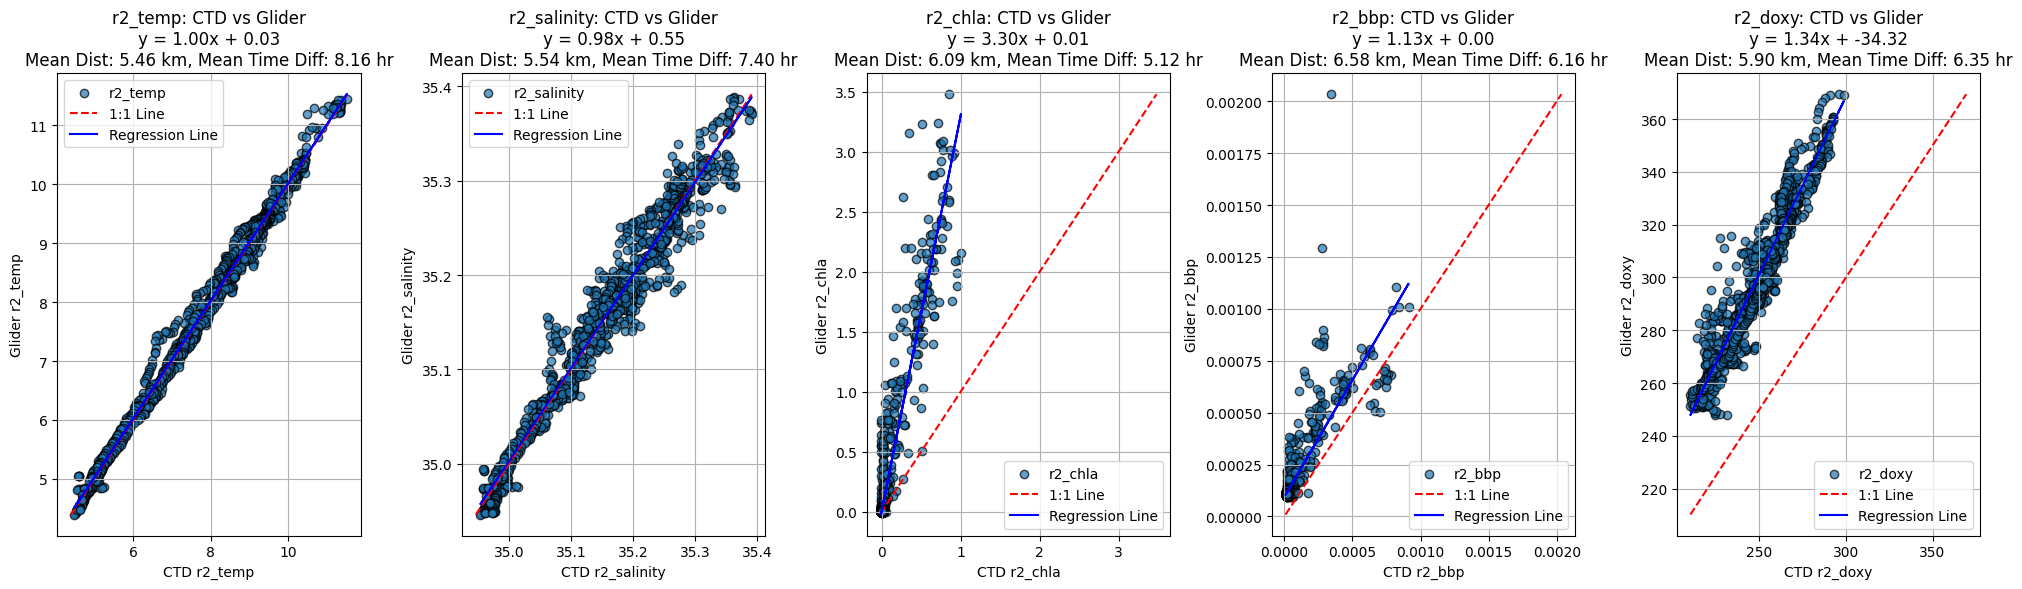

In [25]:
from utils.statistics import get_binned_data, plot_multi_panel_scatter
# Initialize a dictionary to store DataFrames for each variable
variable_dfs = {}

churchill_filtered = r2_df[r2_df['glider_profile_id'].str.contains("Churchill")]
# Iterate over each variable
for var in ['r2_temp', 'r2_salinity', 'r2_chla', 'r2_bbp', 'r2_doxy']:
    # Initialize an empty list to store the rows with the highest R² values for the current variable
    selected_rows = []
    
    # Iterate over each unique CTD profile ID
    for ctd_id in churchill_filtered['ctd_profile_id'].unique():
        # Filter rows for the current CTD profile ID
        ctd_rows = churchill_filtered[churchill_filtered['ctd_profile_id'] == ctd_id]
        
        # Select the row with the highest R² value for the current variable
        max_row = ctd_rows.loc[ctd_rows[var].idxmax()]
        selected_rows.append(max_row)
    
    # Create a DataFrame from the selected rows and store it in the dictionary
    variable_dfs[var] = pd.DataFrame(selected_rows).drop_duplicates()

# Access individual DataFrames using variable_dfs['r2_temp'], variable_dfs['r2_salinity'], etc.

linked_variable_dfs = get_binned_data(variable_dfs, glider_binned, ctd_binned)

plot_multi_panel_scatter(linked_variable_dfs, var_pairs)

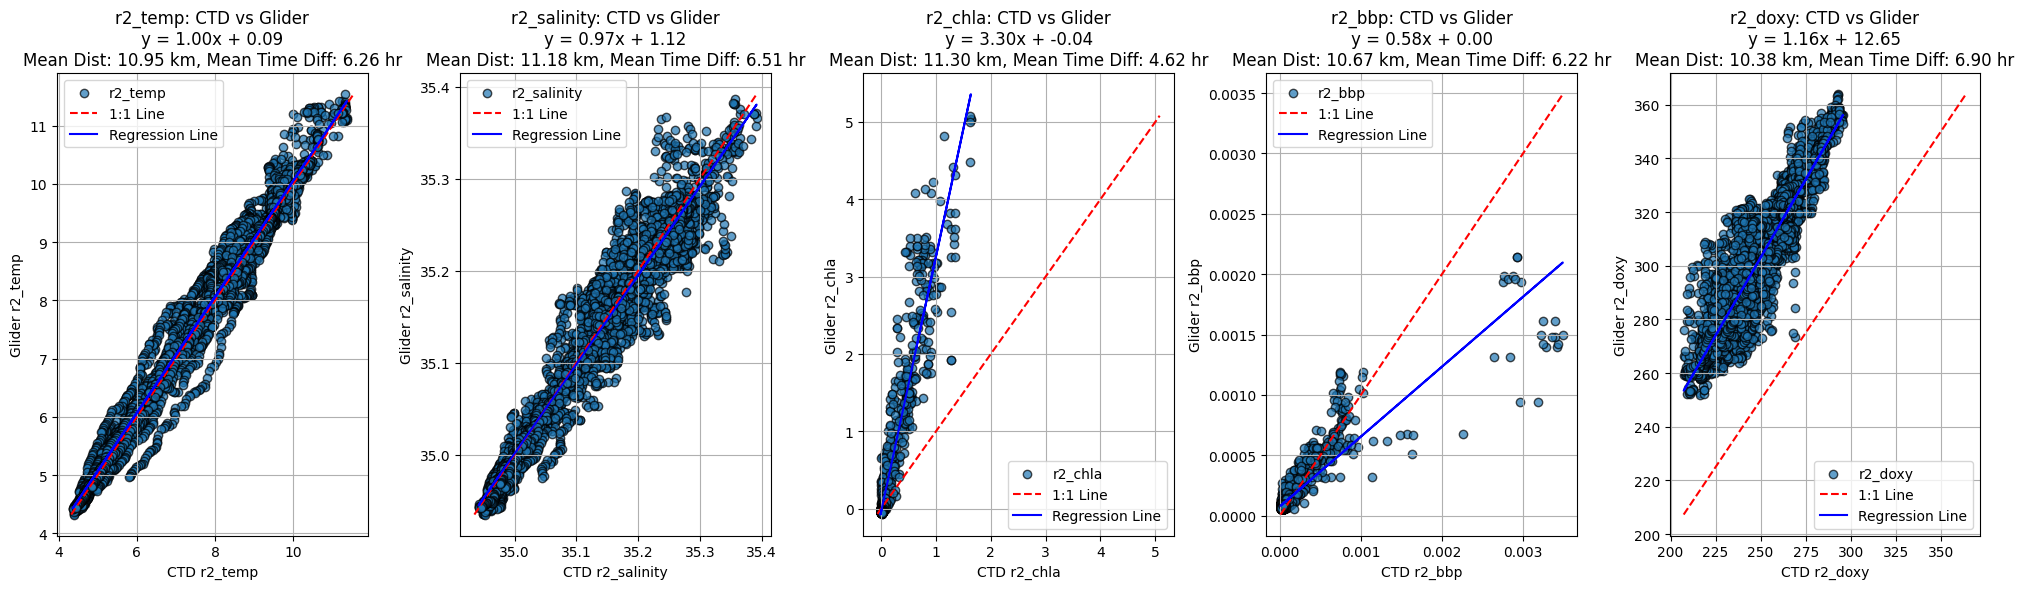

In [26]:
# Initialize a dictionary to store DataFrames for each variable
variable_dfs = {}

churchill_filtered = r2_df[r2_df['glider_profile_id'].str.contains("Nelson")]
# Iterate over each variable
for var in ['r2_temp', 'r2_salinity', 'r2_chla', 'r2_bbp', 'r2_doxy']:
    # Initialize an empty list to store the rows with the highest R² values for the current variable
    selected_rows = []
    
    # Iterate over each unique CTD profile ID
    for ctd_id in churchill_filtered['ctd_profile_id'].unique():
        # Filter rows for the current CTD profile ID
        ctd_rows = churchill_filtered[churchill_filtered['ctd_profile_id'] == ctd_id]
        
        # Select the row with the highest R² value for the current variable
        max_row = ctd_rows.loc[ctd_rows[var].idxmax()]
        selected_rows.append(max_row)
    
    # Create a DataFrame from the selected rows and store it in the dictionary
    variable_dfs[var] = pd.DataFrame(selected_rows).drop_duplicates()

# Access individual DataFrames using variable_dfs['r2_temp'], variable_dfs['r2_salinity'], etc.

linked_variable_dfs = get_binned_data(variable_dfs, glider_binned, ctd_binned)

plot_multi_panel_scatter(linked_variable_dfs, var_pairs)

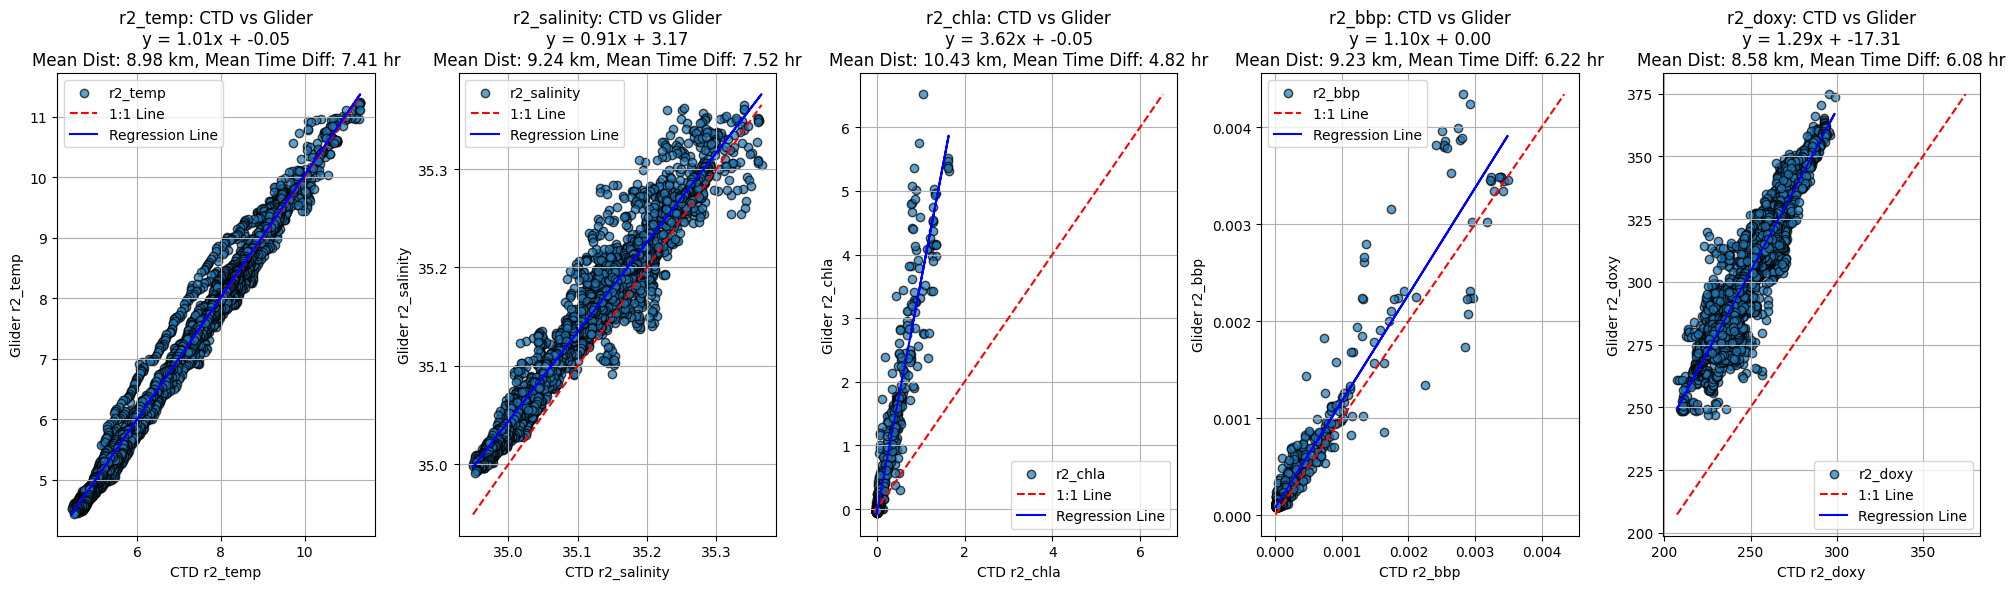

In [27]:
# Initialize a dictionary to store DataFrames for each variable
variable_dfs = {}

churchill_filtered = r2_df[r2_df['glider_profile_id'].str.contains("Cabot")]
# Iterate over each variable
for var in ['r2_temp', 'r2_salinity', 'r2_chla', 'r2_bbp', 'r2_doxy']:
    # Initialize an empty list to store the rows with the highest R² values for the current variable
    selected_rows = []
    
    # Iterate over each unique CTD profile ID
    for ctd_id in churchill_filtered['ctd_profile_id'].unique():
        # Filter rows for the current CTD profile ID
        ctd_rows = churchill_filtered[churchill_filtered['ctd_profile_id'] == ctd_id]
        
        # Exclude rows with NaN values in the current variable
        valid_ctd_rows = ctd_rows[ctd_rows[var].notna()]
        if not valid_ctd_rows.empty:
            # Select the row with the highest R² value for the current variable
            max_row = valid_ctd_rows.loc[valid_ctd_rows[var].idxmax()]
            selected_rows.append(max_row)
    
    # Create a DataFrame from the selected rows and store it in the dictionary
    variable_dfs[var] = pd.DataFrame(selected_rows).drop_duplicates()

# Access individual DataFrames using variable_dfs['r2_temp'], variable_dfs['r2_salinity'], etc.

linked_variable_dfs = get_binned_data(variable_dfs, glider_binned, ctd_binned)

plot_multi_panel_scatter(linked_variable_dfs, var_pairs)

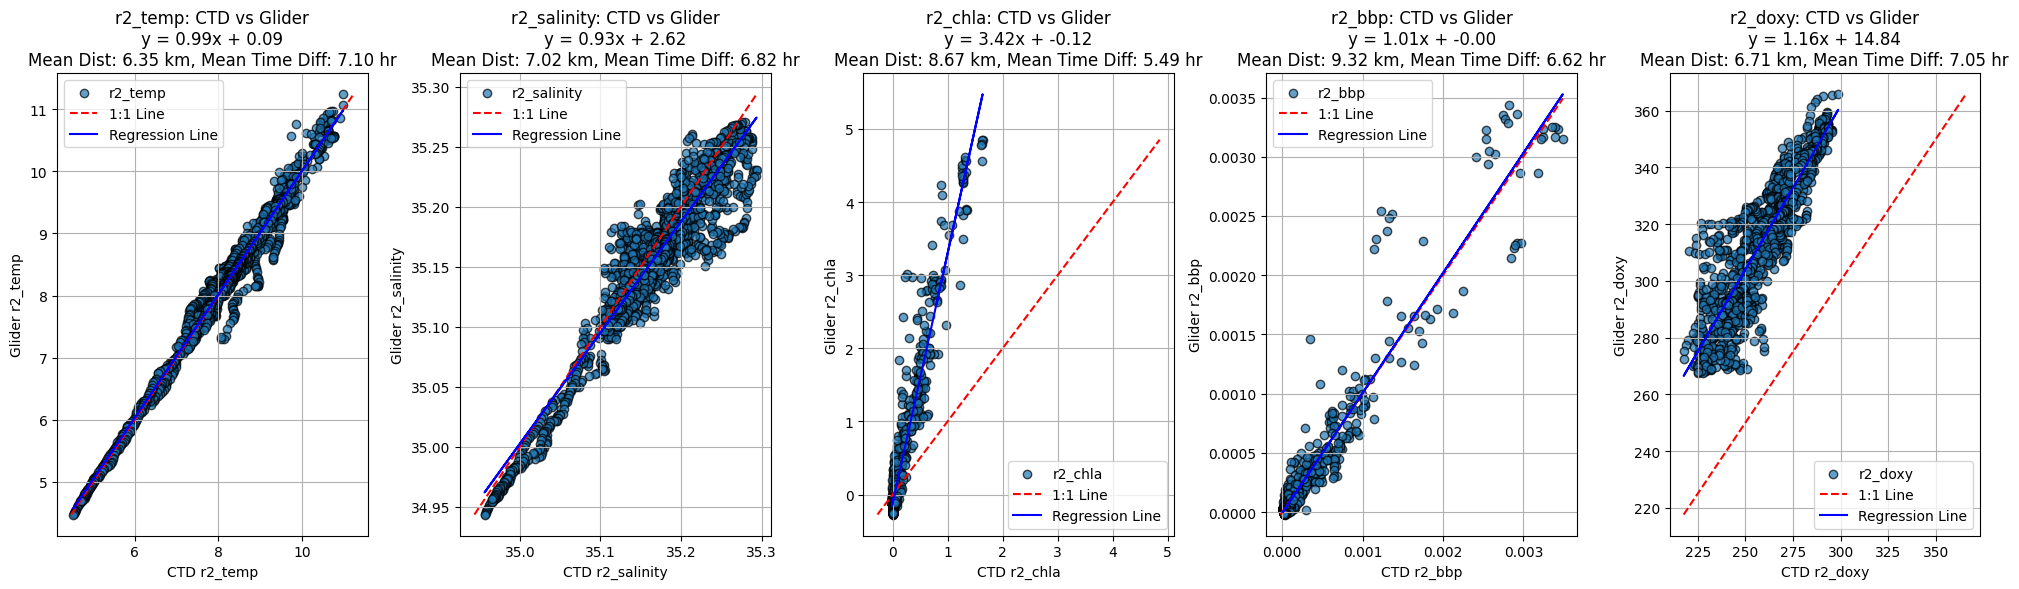

In [28]:
# Initialize a dictionary to store DataFrames for each variable
variable_dfs = {}

churchill_filtered = r2_df[r2_df['glider_profile_id'].str.contains("Doombar")]
# Iterate over each variable
for var in ['r2_temp', 'r2_salinity', 'r2_chla', 'r2_bbp', 'r2_doxy']:
    # Initialize an empty list to store the rows with the highest R² values for the current variable
    selected_rows = []
    
    # Iterate over each unique CTD profile ID
    for ctd_id in churchill_filtered['ctd_profile_id'].unique():
        # Filter rows for the current CTD profile ID
        ctd_rows = churchill_filtered[churchill_filtered['ctd_profile_id'] == ctd_id]
        
        # Exclude rows with NaN values in the current variable
        valid_ctd_rows = ctd_rows[ctd_rows[var].notna()]
        if not valid_ctd_rows.empty:
            # Select the row with the highest R² value for the current variable
            max_row = valid_ctd_rows.loc[valid_ctd_rows[var].idxmax()]
            selected_rows.append(max_row)
    
    # Create a DataFrame from the selected rows and store it in the dictionary
    variable_dfs[var] = pd.DataFrame(selected_rows).drop_duplicates()

# Access individual DataFrames using variable_dfs['r2_temp'], variable_dfs['r2_salinity'], etc.

linked_variable_dfs = get_binned_data(variable_dfs, glider_binned, ctd_binned)

plot_multi_panel_scatter(linked_variable_dfs, var_pairs)